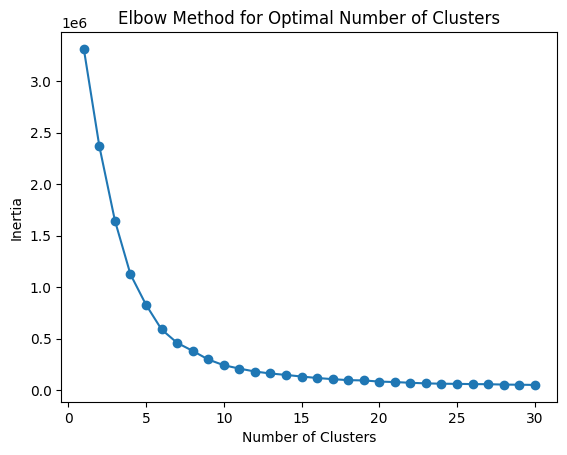

c:\Users\kenta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [2]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load the point cloud data
file_data = np.fromfile(r'C:\Users\kenta\Documents\Point_Cloud_Clustering\lidar_data\frame1.pcd.bin', dtype=np.float32)
points = file_data.reshape((-1, 5))[:, :4]

## Preprocess the point cloud

# Remove ground points using RANSAC based on elevation and inclination
ground_threshold = 0.4
inclination_threshold = 10

# Create an Open3D point cloud object
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points[:, :3])

# Fit a plane using RANSAC
plane_model, inliers = pcd.segment_plane(distance_threshold=0.1, ransac_n=3, num_iterations=1000)

# Extract the plane parameters
a, b, c, d = plane_model

# Calculate the elevation of each point from the plane
elevations = np.abs((a * points[:, 0] + b * points[:, 1] + c * points[:, 2] + d) / np.sqrt(a ** 2 + b ** 2 + c ** 2))

# Calculate the inclination of the plane
inclination = np.arccos(np.abs(c)) * (180 / np.pi)

# Find the indices of non-ground points based on elevation and inclination thresholds
non_ground_indices = np.where((elevations > ground_threshold) | (inclination > inclination_threshold))[0]

# Create a new point cloud with only non-ground points
non_ground_points = points[non_ground_indices]

# Remove outliers using statistical outlier removal
filtered_pcd_temp = o3d.geometry.PointCloud()
filtered_pcd_temp.points = o3d.utility.Vector3dVector(non_ground_points[:, :3])
filtered_pcd, ind = filtered_pcd_temp.remove_statistical_outlier(nb_neighbors=200, std_ratio=1)

## Perform lidar clustering using K-means

points_np = np.asarray(filtered_pcd.points)

# Perform K-means clustering for a range of cluster numbers
max_clusters = 30
inertia_values = []

for num_clusters in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10, max_iter=300, tol=1e-4, random_state=0)
    kmeans.fit(points_np)
    inertia_values.append(kmeans.inertia_)

# Plot the inertia values to find the optimal number of clusters using the elbow method
plt.plot(range(1, max_clusters + 1), inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# Choose the optimal number of clusters and perform K-means clustering

optimal_num_clusters = 10  # Choose the optimal number of clusters based on the elbow method

kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=0)
kmeans.fit(points_np)
labels = kmeans.labels_

# Assign colors to clusters
max_label = labels.max()
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0

# Assign colors to Open3D point cloud
filtered_pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])

# Generate bounding boxes
bounding_boxes = []

for cluster_label in range(optimal_num_clusters):
    cluster_points = points_np[labels == cluster_label]

    # Generate bounding box for the cluster points
    min_bound = np.min(cluster_points, axis=0)
    max_bound = np.max(cluster_points, axis=0)
    bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound[:3], max_bound[:3])

    # Set the color of the bounding box
    bbox.color = (1, 0, 0) 

    # Add the bounding box to the list
    bounding_boxes.append(bbox)

# Make the point cloud denser using voxel down-sampling
dense_pcd = filtered_pcd.voxel_down_sample(voxel_size=0.001)

## Visualize the clustered point cloud with bounding boxes, ground point cloud, outliers, and dense point cloud

# Extract ground points using the inverted boolean condition
ground_points = points[np.logical_not((elevations > ground_threshold) | (inclination > inclination_threshold))]

# Create an Open3D point cloud object for the ground points
ground_pcd = o3d.geometry.PointCloud()
ground_pcd.points = o3d.utility.Vector3dVector(ground_points[:, :3])

# Create an Open3D point cloud object for the outliers
outlier_points = points[non_ground_indices]
outlier_pcd = o3d.geometry.PointCloud()
outlier_pcd.points = o3d.utility.Vector3dVector(outlier_points[:, :3])

# Add the ground point cloud, clustered point cloud, outliers, bounding boxes, and dense point cloud to the visualization
o3d.visualization.draw_geometries([dense_pcd] + bounding_boxes + [ground_pcd] + [outlier_pcd])